In [1]:
import torch
from torch.utils.data import DataLoader
from dataset import YoloDarknetDataset
from torchvision import transforms
import os
from model import model_builder
import lightnet as ln
from test_script import test_step
from utils import draw_bounding_boxes, mean_average_precision, to_pixel_coords, to_xyxy_coords, load_config
from lightnet.util import iou_cwh, iou_tlwh
import numpy as np
from pathlib import Path

/home/gustavo/workstation/depth_estimation/codes/rgbd-yolov2/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
config = load_config("configs/train_anyv2_wizard.yaml")


BASE_DIR = config["base_dir"]
TRAIN_IMG_DIR = config["train_img_dir"]
TRAIN_DEPTH_DIR = config["train_depth_dir"]
TRAIN_LABEL_DIR =  config["train_label_dir"]
BATCH_SIZE = config["batch_size"]
NUM_WORKERS = config["num_workers"]
LEARNING_RATE = config["learning_rate"]
NUM_EPOCHS = config["num_epochs"]
MODEL_TYPE = config["model_type"]
FUSE_LAYER = config["fuse_layer"]
DATASET_NAME = config["dataset_name"]
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_CLASSES = 3

TRAIN_IMG_DIR =  BASE_DIR + TRAIN_IMG_DIR
TRAIN_DEPTH_DIR = BASE_DIR + TRAIN_DEPTH_DIR
TRAIN_LABEL_DIR = BASE_DIR + TRAIN_LABEL_DIR

In [3]:
print(config)
print(f"Using Device {DEVICE}")

# model = ln.models.YoloV2(NUM_CLASSES)
# model.load('models/5_epochs_split.pt', strict=False)
# model.to(DEVICE)

model = model_builder(num_classes=NUM_CLASSES, model_type=MODEL_TYPE, fuse_layer=FUSE_LAYER)
model.load("models/anythingv2_best.pth")
model.to("cpu")

loss_fn = ln.network.loss.RegionLoss(
    num_classes= model.num_classes,
    anchors=model.anchors,
    network_stride=model.stride
)

test_transforms = transforms.Compose([
    transforms.Resize((416, 416)),
    transforms.ToTensor()
])

test_dataset = YoloDarknetDataset(
    images_dir="data/image_splits/test/images",
    depth_dir="data/Depth_anything_v2/test/depth",
    labels_dir="data/image_splits/test/labels",
    classes=["Cyclist", "Pedestrian", "Car"],
    transform=test_transforms,
    model_type=MODEL_TYPE
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

{'dataset_name': 'anythingv2', 'base_dir': '/home/gkmo/workspace/data', 'train_img_dir': '/image_splits/train/images', 'train_depth_dir': '/Depth_anything_v2/train/depth', 'train_label_dir': '/image_splits/train/labels', 'batch_size': 16, 'num_workers': 16, 'learning_rate': 0.01, 'num_epochs': 500, 'device': 'cuda', 'model_type': 'rgbd', 'fuse_layer': 15}
Using Device cuda
Weights equivalent


/home/gustavo/workstation/depth_estimation/codes/rgbd-yolov2/.venv/lib/python3.10/site-packages/lightnet/network/module/_lightnet.py:293: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental 

In [4]:
do_test = True
if do_test:
    metric_map, test_loss, pred_boxes, true_boxes = test_step(
        model=model,
        dataloader=test_dataloader,
        batch_size=BATCH_SIZE,
        loss_fn=loss_fn,
        device=DEVICE
    )

KeyboardInterrupt: 

In [ ]:
metric_map

(tensor(0.3159), [tensor(0.2047), tensor(0.1300), tensor(0.6130)])

In [ ]:
def plot_result(model,
                idx,
                images_dir,
                depth_dir,
                device):


In [82]:
from PIL import Image
import matplotlib.pyplot as plt

train_transforms = transforms.Compose([
    transforms.Resize((416, 416)),
    transforms.ToTensor()
])

inv_transforms = transforms.Compose([
    transforms.Resize((375, 1242)),
    transforms.ToPILImage()
])


index = 3

model.eval()
model.to("cpu")

# Load image and ground truth
image, target = test_dataset[index]
target = target["boxes"]
#image = image.to("cpu").unsqueeze(0)  # Add batch dimension
ground_truth_boxes = target[:, 1:]  # Get the ground truth bounding boxes
ground_truth_classes = target[:, 0].int()  # Get the ground truth class IDs

In [88]:
images_dir = Path("data/image_splits/test/images")
depth_dir = Path("data/Depth_anything_v2/test/depth")
idx = 3

image_files = sorted([p for p in images_dir.glob('*') if p.suffix in ['.jpg', '.jpeg', '.png']])

depth_files = sorted([p for p in depth_dir.glob('*') if p.suffix in ['.jpg', '.jpeg', '.png']])

img_path = image_files[idx]
depth_path = depth_files[idx]

rgb_image = Image.open(img_path).convert("RGB") 
depth_image = Image.open(depth_path).convert("L")

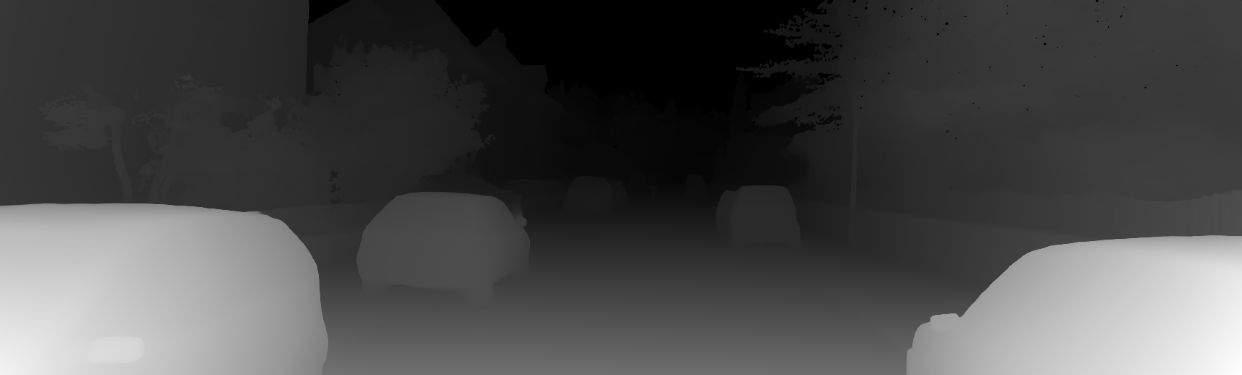

In [91]:
depth_image

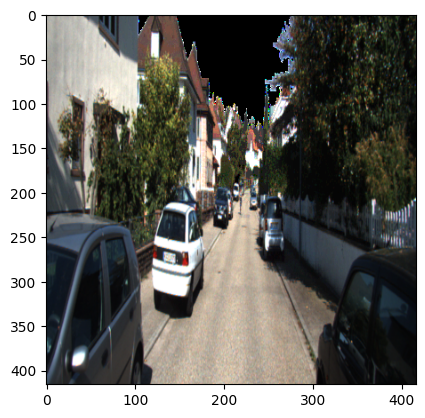

In [85]:
plt.imshow(image[0:3, :, :].permute(1,2,0))

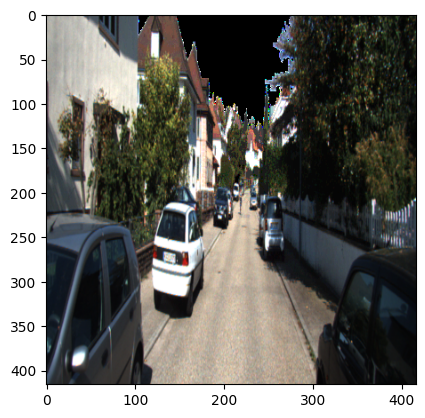

In [68]:
plt.imshow(image.squeeze(0).permute(1,2,0)[:, :, :3])

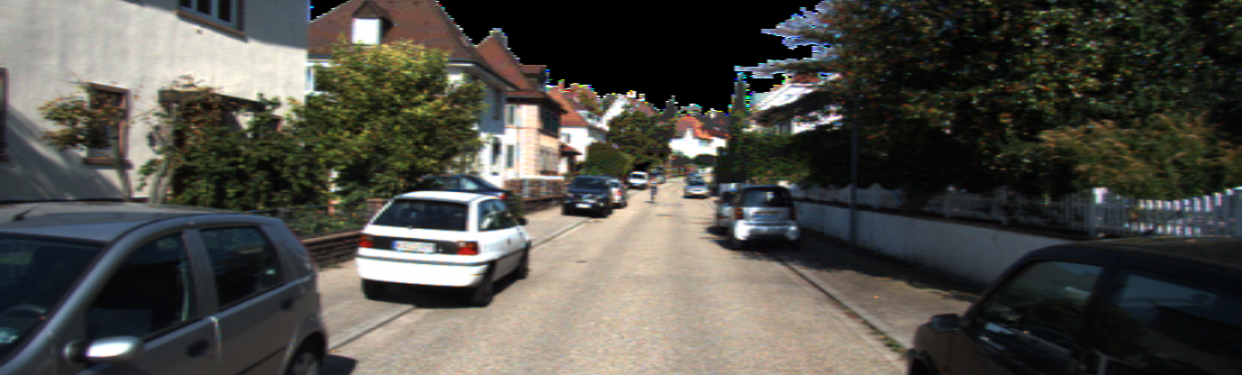

In [87]:
inv_transforms(image[0:3, :, :])

In [ ]:
plt.imshow()

ValueError: pic should be 2/3 dimensional. Got 4 dimensions.

In [92]:
images_dir = Path("data/image_splits/test/images")
depth_dir = Path("data/Depth_anything_v2/test/depth")
idx = 3

image_files = sorted([p for p in images_dir.glob('*') if p.suffix in ['.jpg', '.jpeg', '.png']])

depth_files = sorted([p for p in depth_dir.glob('*') if p.suffix in ['.jpg', '.jpeg', '.png']])

img_path = image_files[idx]
depth_path = depth_files[idx]

rgb_image = Image.open(img_path).convert("RGB") 
depth_image = Image.open(depth_path).convert("L")

# Convert images to numpy arrays
rgb_array = np.array(rgb_image)  # Shape: (H, W, 3)
depth_array = np.array(depth_image)  # Shape: (H, W)

depth_array = np.expand_dims(depth_array, axis=-1)  # Shape: (H, W, 1)

four_channel_array = np.concatenate((rgb_array, depth_array), axis=-1)  # Shape: (H, W, 4)

img = Image.fromarray(four_channel_array, mode="RGBA")

rgbd_tensor = train_transforms(img).unsqueeze(0)  # Shape: [1, 4, 416, 416]

# Run the model to get predictions
with torch.inference_mode():
    predictions = model(rgbd_tensor)

# # Apply GetBoxes to transform the model output into bouding box format
# predictions = GetBoxes_fn(predictions.cpu())

# # Apply NMS to the predictions
# predictions = nms_fn(predictions)

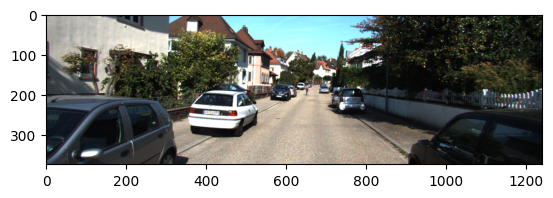

In [96]:
plt.imshow(four_channel_array[:, :, :3])

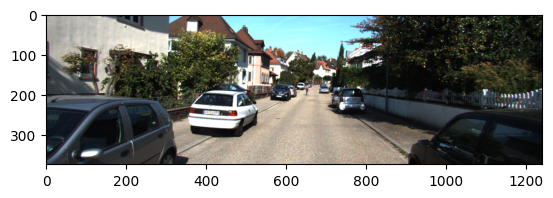

In [98]:
plt.imshow(np.array(img)[:,:, :3])

In [105]:
transform = transforms.ToTensor()

tensor_resultado = train_transforms(img)

def transform_and_resize(img):
    transform = transforms.ToTensor()
    tensor_img = transform(img)
    tensor_resized = torch.nn.functional.interpolate(tensor_img.unsqueeze(0), size=(416, 416))
    return tensor_resized


tensor_manual = transform_and_resize(img)


In [106]:
tensor_manual.shape

torch.Size([1, 4, 416, 416])

In [102]:
tensor_resultado.shape

torch.Size([4, 416, 416])

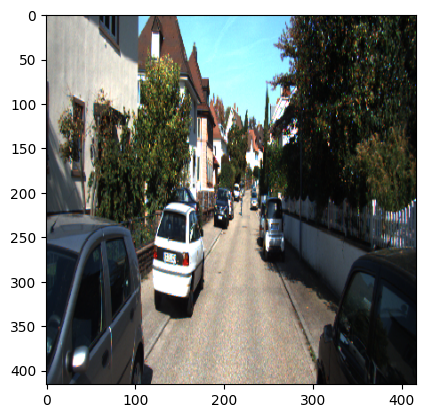

In [108]:
plt.imshow(tensor_manual.squeeze(0).permute(1,2,0)[:,:,:3])

torch.Size([4, 416, 416])
<class 'torch.Tensor'>


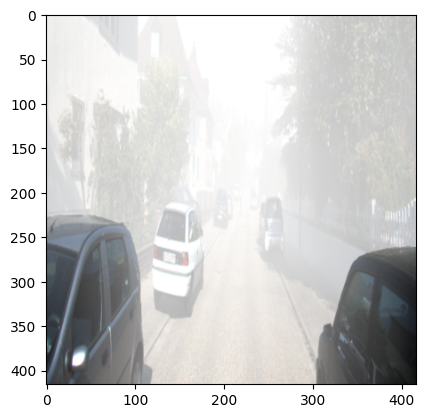

In [ ]:
import matplotlib.pyplot as plt
index = 3
image, target = test_dataset[index]
print(image.shape)
print(type(image))
plt.imshow(image.squeeze(0).permute(1,2,0))

In [ ]:
def draw_bounding_boxes(index, model, dataset, GetBoxes_fn, nms_fn, class_names, device="cpu"):
    """
    Draws bounding boxes on an image with predictions and ground truths.

    Args:
        index (int): Index of the image in the dataset.
        model (torch.nn.Module): Trained YOLOv2 model.
        dataset (torch.utils.data.Dataset): Dataset containing the images and labels.
        nms_fn (function): Non-Maximum Suppression function to filter model outputs.
        class_names (list of str): List of class names.
        device (str): Device to run the model on ("cpu" or "cuda").
    """
    model.eval()
    model.to(device)

    # Load image and ground truth
    image, target = dataset[index]
    target = target["boxes"]
    image = image.to(device).unsqueeze(0)  # Add batch dimension
    ground_truth_boxes = target[:, 1:]  # Get the ground truth bounding boxes
    ground_truth_classes = target[:, 0].int()  # Get the ground truth class IDs

    # Run the model to get predictions
    with torch.inference_mode():
        predictions = model(image)

    # Apply GetBoxes to transform the model output into bouding box format
    predictions = GetBoxes_fn(predictions.cpu())

    # Apply NMS to the predictions
    predictions = nms_fn(predictions)
    
    # Convert the image back to a PIL format for visualization
    image = to_pil_image(image.squeeze(0).cpu())  # Remove batch dimension

    # Plot the image
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    


    # Draw ground truth bounding boxes
    img_width, img_height = image.size
    for i, gt_box in enumerate(ground_truth_boxes):
        if ground_truth_classes[i] == -1:  # Ignore padded values
            continue
        x, y, w, h = to_pixel_coords(gt_box.cpu(), img_width, img_height)
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor="green", facecolor="none")
        ax.add_patch(rect)
        ax.text(x, y - 10, class_names[ground_truth_classes[i]], color="green", fontsize=12, weight="bold")

    # Draw predicted bounding boxes
    for pred in predictions:
        #img_width=1 and img_heith=1 because the predictions weren't normalized
        x, y, w, h = to_pixel_coords(pred[1:5].cpu(), img_width=1, img_height=1)
        score = pred[5].item()
        class_id = int(pred[6].item())
        
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor="red", facecolor="none")
        ax.add_patch(rect)
        ax.text(x, y - 10, f"{class_names[class_id]}: {score:.2f}", color="red", fontsize=12, weight="bold")

    plt.axis("off")
    plt.show()


In [11]:
GetBoxes_fn = ln.data.transform.GetAnchorBoxes(
                conf_thresh=0.5,
                network_stride=model.stride,
                anchors=model.anchors
            )

nms_fn = ln.data.transform.NMS(
    iou_thresh=.3,
    class_nms=True
)

In [14]:
# good indexes: 785, 512, 1023

draw_bounding_boxes(index=0, 
                    model=depth_model, 
                    dataset=test_dataset, 
                    GetBoxes_fn=GetBoxes_fn, 
                    nms_fn=nms_fn, 
                    class_names=["1", "2", "3"], 
                    device=DEVICE)

NameError: name 'depth_model' is not defined

In [8]:
mean_average_precision(pred_boxes=pred_boxes, true_boxes=true_boxes, iou_threshold=0.5, box_format="corners", num_classes=3)

(tensor(0.1261), [tensor(0.), tensor(0.), tensor(0.3782)])